<a href="https://colab.research.google.com/github/persisbb/DetectPneumonia/blob/main/Detect_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
# Unzipping the data
!unzip -q "archive.zip"

--2023-06-21 14:17:32--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2023-06-21 14:17:33--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2dc5fd5c34d47caccfa6da561e.dl.dropboxusercontent.com/cd/0/inline/B-aIwTAWMlYz-_T3wtzqb9VFv8SKQpF1Z3yUD0Vg-wFNGb5cXJD9LPrmQ-Nrb_8vM8zjLMSBO3yqTCBwuUhCHevW-lsL8sDyCrqz1Y5m1UvX7nLB8RZz_F__BIauo0Y_tgi7FT_5vYcW3d660LQM4L2Tsxk-f7AP3h_fe1SvnmCw7g/file# [following]
--2023-06-21 14:17:33--  https://uc2dc5fd5c34d47caccfa6da561e.dl.dropboxusercontent.com/cd/0/inline/B-aIwTAWMlYz-_T3wtzqb9VFv8SKQpF1Z3yUD0Vg-wFNGb5cXJD9LPrmQ-Nrb_8vM8zjLMSBO3yqTCBwu

In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [ ]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7fed83187060>


In [ ]:
# Convert Generator Object to List of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0893-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0660-0001-0002.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0529-0001.jpeg')]


In [ ]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths))

print(train_image_paths[:3])

['chest_xray/train/NORMAL/NORMAL2-IM-0893-0001.jpeg', 'chest_xray/train/NORMAL/IM-0660-0001-0002.jpeg', 'chest_xray/train/NORMAL/IM-0529-0001.jpeg']


In [ ]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [ ]:
# Every Image has Label in its path , so lets slice it
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [ ]:
# Now we have all training, validation image paths and their respective labels

BATCH_SIZE = 32  #no of images to load into a method

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 960 ms, sys: 560 ms, total: 1.52 s
Wall time: 3.48 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


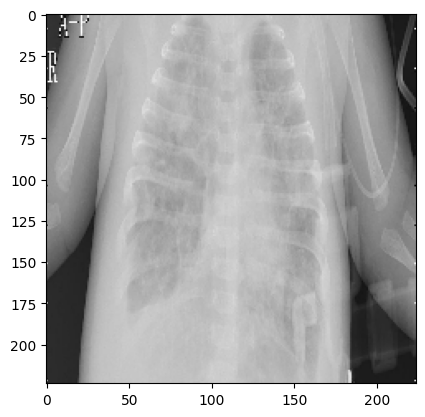

In [ ]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 26.7 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


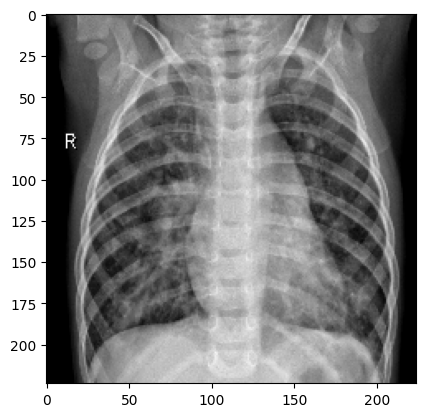

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)
#since our model is a "yes" or "no" model we will have to remove the last layer and make our own layer
#therefore use include_top=flase

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#sigmoid here because it is a yes or no problem statement and sigmoid does exactly that.Its outputs either zero or one.
model.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

#The loss is set to binary_crossentropy as we are solving a binary classification problem.
#If your problem statement is multiclass, then you need to go with categorical_crossentropy

#The metrics are the stats that we want to keep track of while training our model
#as this is a medicalproblem, we added precision and recall to the metrics list.

In [ ]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9419 - precision: 0.9568 - recall: 0.9555
Epoch 1: val_loss improved from inf to 24.03923, saving model to best_weights.h5
163/163 [==============================] - 135s 418ms/step - loss: 0.1544 - accuracy: 0.9419 - precision: 0.9568 - recall: 0.9555 - val_loss: 24.0392 - val_accuracy: 0.6826 - val_precision: 0.6667 - val_recall: 0.9922
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9691 - precision: 0.9775 - recall: 0.9808
Epoch 2: val_loss improved from 24.03923 to 0.68047, saving model to best_weights.h5
163/163 [==============================] - 69s 422ms/step - loss: 0.0839 - accuracy: 0.9691 - precision: 0.9775 - recall: 0.9808 - val_loss: 0.6805 - val_accuracy: 0.8684 - val_precision: 0.8379 - val_recall: 0.9761
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9634 - precision: 0.9740 - recall: 0.9767
Epoc

KeyboardInterrupt: ignored

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [ ]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)